In [9]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

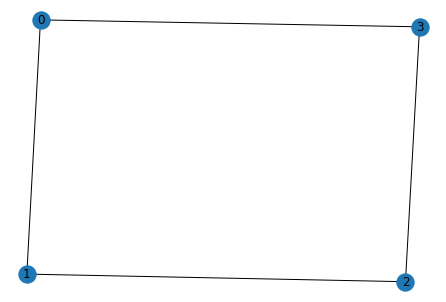

In [14]:
n_nodes = 4
edges = [(0, 1), (1, 2), (2, 3), (0, 3)]
graph = nx.Graph(edges)
nx.draw(graph, with_labels=True)
plt.show()

In [152]:
def U_B(beta):
    for edge in edges:
        qml.RX(2 * beta, wires=edge[1])
        # print(f'U_B applied to wire {edge[1]}')

def U_C(gamma):
    for edge in edges:
        qml.CNOT(wires=[edge[0], edge[1]])
        qml.RZ(gamma, wires=edge[1])
        qml.CNOT(wires=[edge[0], edge[1]])

In [153]:
def measure_computational_basis(wires):
    n_wires = n_nodes
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [199]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)

# if it's the erro w default.qubit, then the error must be in the circuit function.
dev = qml.device('default.qubit', wires=n_nodes, shots=1) # here the parameter/attribute "wires" means n_wires
@qml.qnode(dev)
def circuit(betas, gammas, edge=None, n_layers=1):
    for i in range(n_nodes):
        qml.Hadamard(wires=i) # Apply Hadamard to each node, to initialize in state |E>. here "wires" means wire_number (ordinal number)
    for i in range(n_layers): # Apply U_B and U_C n_layers number of times
        U_C(gammas[i])
        U_B(betas[i]) # betas [i] because ith element in the betas array, there will be n_layers amount of parameters in array beta, one for each layer.
        

    if edge is None: # what is "is" keyword? old: if edge == None
        # print(f'1: {qml.sample(Hermitian(pauli_z_2, wires=edge))}')
        
        x = qml.sample(measure_computational_basis(range(n_nodes))) # what is qml.sample? docs. old: wires = range(n_nodes)
        # print(x)
        return(x)
        # i did get past here. now that this is returned, oh shit can't be wires = edge bc there is no edge.

    # x = qml.expval(qml.Hermitian(pauli_z_2, wires=edge))
    # print(x)
    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

# qml.draw(circuit)

In [210]:
def qaoa_maxcut(n_layers):
    initial_params = 0.1*np.random.rand(2, 3) 
    print(initial_params)

    def neg_objective(params):
        objective = 0
        for edge in edges:
            objective += 0.5 * (1- circuit(params[0], params[1], edge=edge, n_layers=n_layers)) # added 0.5* ( 1-
        return -objective
    
    opt = qml.AdagradOptimizer(stepsize=0.5)
    params = initial_params
    n_steps = 30
    for i in range(n_steps):
        params = opt.step(neg_objective, params)
        print(f'Step: {i} | Objective: {- neg_objective(params)}') # this aint optimizing lol
    print(f'Optimal params: {params}')

    bit_strings = []
    for i in range(100):
        bit_strings.append(int(circuit(params[0], params[1], edge=None, n_layers=n_layers))) # added int

    # find most common bitstring
    # counts = np.bincount(np.array(bit_strings))
    # most_freq_bit_string = np.argmax(counts)
    # print("most frequently sampled bitstring is " + most_freq_bit_string) 

    # my objective function is fucked 

    return params, bit_strings

In [216]:
bitstrings1 = qaoa_maxcut(n_layers=1)[1]
bitstrings2 = qaoa_maxcut(n_layers=2)[1]
bitstrings3 = qaoa_maxcut(n_layers=3)[1]
# oh wait objective is supposed to be the NUMBER OF CUT EDGES

[[0.08084978 0.08087584 0.07642275]
 [0.00847978 0.07230092 0.0388681 ]]
Step: 0 | Objective: 1.3095355376437228
Step: 1 | Objective: 2.0294496092391965
Step: 2 | Objective: 2.0995858835698185
Step: 3 | Objective: 2.15550956166656
Step: 4 | Objective: 2.185210374292028
Step: 5 | Objective: 2.181221646647614
Step: 6 | Objective: 2.13954376460955
Step: 7 | Objective: 2.1003714086991954
Step: 8 | Objective: 2.214763682040358
Step: 9 | Objective: 2.216654533979274
Step: 10 | Objective: 2.2163761891607754
Step: 11 | Objective: 2.2171005359443994
Step: 12 | Objective: 2.216136448451018
Step: 13 | Objective: 2.21709491319184
Step: 14 | Objective: 2.216277246963341
Step: 15 | Objective: 2.2175089114589284
Step: 16 | Objective: 2.217057824432132
Step: 17 | Objective: 2.2182426532795967
Step: 18 | Objective: 2.2180967211020963
Step: 19 | Objective: 2.2190285294504064
Step: 20 | Objective: 2.2190526229946617
Step: 21 | Objective: 2.2197032670094115
Step: 22 | Objective: 2.2197928503372397
Step: 2

In [217]:
for i in range(2):
    print(i)
    # range starts at 0

0
1


In [218]:
print(bitstrings1)


[1, 5, 3, 13, 13, 2, 14, 14, 3, 3, 3, 7, 12, 15, 3, 5, 11, 14, 14, 14, 14, 2, 2, 2, 13, 12, 3, 0, 5, 10, 1, 3, 13, 10, 1, 12, 12, 11, 1, 13, 3, 4, 11, 11, 12, 1, 12, 1, 3, 10, 10, 11, 5, 12, 12, 12, 9, 15, 3, 13, 1, 3, 10, 1, 2, 10, 12, 12, 15, 12, 10, 3, 3, 3, 1, 2, 3, 4, 12, 1, 2, 2, 5, 1, 11, 14, 1, 3, 5, 14, 15, 2, 1, 12, 12, 9, 1, 1, 12, 3]


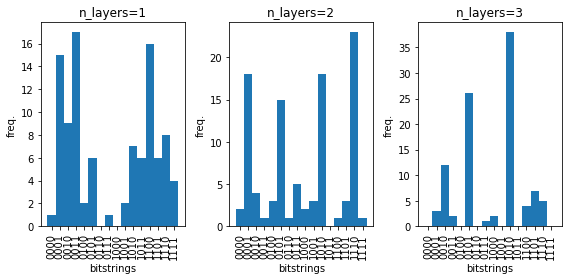

In [221]:
xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.title("n_layers=1")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings1, bins=bins)

plt.subplot(1, 3, 2)
plt.title("n_layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)

plt.subplot(1, 3, 3)
plt.title("n_layers=3")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings3, bins=bins)


plt.tight_layout()
plt.show()

In [ ]:
# error: circuit was wrong, put U_B before U_C

# it's not the right answer!!!! with n_layers = 2, the answer is 1110 and 0001.